In [2]:
import os
import shutil
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision import datasets
import PIL
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import einops
import wandb
import PIL
import sys
from collections import OrderedDict

In [2]:
train_transform = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor()
                           ])

In [3]:
dataset = datasets.ImageFolder(f'./food-101/images/', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, drop_last = True, num_workers=4, pin_memory = True)

In [4]:
class decoder(nn.Module):

    def __init__(self, out_channels=3, init_features=2048):
        super(decoder, self).__init__()
        self.out_channels = out_channels

        features = init_features
        self.from_latent =  nn.ConvTranspose2d(features, features//4, kernel_size=4, stride=1,bias=False)
        
        self.upconv6 = nn.ConvTranspose2d(features//4, features//8, kernel_size=2, stride=2,bias=False)
        self.decoder6 = decoder._block(features//8, features//8, name="dec4")
        self.upconv5 = nn.ConvTranspose2d(features//8, features//16, kernel_size=2, stride=2,bias=False)
        self.decoder5 = decoder._block(features//16, features//16, name="dec4")
        self.upconv4 = nn.ConvTranspose2d(features//16, features//32, kernel_size=2, stride=2,bias=False)
        self.decoder4 = decoder._block(features//32, features//32, name="dec3")
        self.upconv3 = nn.ConvTranspose2d(features//32, features//64, kernel_size=2, stride=2,bias=False)
        self.decoder3 = decoder._block(features//64, features//64, name="dec2",kernel_size=7,padding=1)
        self.upconv2 = nn.ConvTranspose2d(features//64, features//128, kernel_size=2, stride=2,bias=False)
        self.decoder2 = decoder._block(features//128, features//128, name="dec1",kernel_size=7,padding=1)
        self.upconv1 = nn.ConvTranspose2d(features//128, features//256, kernel_size=2, stride=2,bias=False)
        self.decoder1 = decoder._block(features//256, features//256, name="dec1",kernel_size=7,padding=0)

        self.conv = nn.Conv2d(in_channels=features//256, out_channels=out_channels, kernel_size=3,bias=False)                                   
        
        self.u_stage6 = nn.Sequential(self.upconv6,
                                      self.decoder6)
        
        self.u_stage5 = nn.Sequential(self.upconv5,
                                      self.decoder5)
        
        self.u_stage4 = nn.Sequential(self.upconv4,
                                      self.decoder4)
        
        self.u_stage3 = nn.Sequential(self.upconv3,
                                      self.decoder3)
        
        self.u_stage2 = nn.Sequential(self.upconv2,
                                      self.decoder2)
        
        self.u_stage1 = nn.Sequential(self.upconv1,
                                      self.decoder1,
                                      self.conv
                                     )

        self.decoder = nn.Sequential(self.u_stage5,
                                     self.u_stage4,
                                     self.u_stage3,
                                     self.u_stage2,
                                     self.u_stage1,
                                     self.from_latent,
                                    )
        

    def forward(self, x):
        x = x.unsqueeze(2).unsqueeze(2)
        x = self.from_latent(x)

        # if mode >=5:
        x = self.u_stage6(x)
        x = self.u_stage5(x)
        # if mode >=4:
        x = self.u_stage4(x)
        # if mode >=3:
        x = self.u_stage3(x)
        # if mode >=2:
        x = self.u_stage2(x)
        # if mode >=1:
        x = self.u_stage1(x)
        return x


    # @staticmethod
    def _block(in_channels, features, name,kernel_size=3,padding=1):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=kernel_size,
                            padding=padding,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                ]
            )
        )
    


In [5]:
model = decoder(out_channels=3,init_features=2048)

In [6]:
data_iter = iter(dataloader)
batch = next(data_iter)
encoder,_ = resnet.resnet50()

In [7]:
# checkpoint = torch.load("./resnet50.pth")
# encoder.load_state_dict(checkpoint)

In [8]:
auto_encoder = nn.Sequential(encoder,model)

In [9]:
optimizer = torch.optim.AdamW(auto_encoder.parameters(), lr = 0.001, weight_decay=0.05)
criterion = nn.BCEWithLogitsLoss()
device = "cuda:1"
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose = True,threshold = 0.001,patience = 5, factor = 0.5)
n_epochs = 10

In [10]:
# encoder.eval()
l = []
auto_encoder  = auto_encoder.to(device)
# encoder = encoder.to(device)
scaler = torch.cuda.amp.GradScaler()
for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_steps = 0
    test_steps = 0
    auto_encoder.train()
    for image, label in tqdm(dataloader):
        image = image.to(device)
        #optimizer.zero_grad()
        for param in auto_encoder.parameters():
            param.grad = None
    
        with torch.cuda.amp.autocast():
            outputs = auto_encoder(image)
            loss = criterion(outputs, image)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        train_steps += 1
    train_loss = train_loss/train_steps
    l.append(train_loss)
    print(f"Epoch {epoch} complete")
    print("Training loss",train_loss)
    print("============================")
    scheduler.step(train_loss)

  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning:

Epoch 0 complete
Training loss 0.6007515692771389


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 1 complete
Training loss 0.5625233734924782


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 2 complete
Training loss 0.5541386593719424


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:02<0

Epoch 3 complete
Training loss 0.549821352746886


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 4 complete
Training loss 0.5463015464356709


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:02<0

Epoch 5 complete
Training loss 0.5437767405800408


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 6 complete
Training loss 0.5416019071782301


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 7 complete
Training loss 0.539516818704944


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 8 complete
Training loss 0.5376903090985293


  0%|                                                                                           | 0/394 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|█████████████████████████████████████████████████████████████████████████████████| 394/394 [03:01<0

Epoch 9 complete
Training loss 0.5359922561246127


In [15]:
state = {
    'epoch': epoch,
    'state_dict': auto_encoder.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, "ae.pt")

In [16]:
model.eval()
data_iter = iter(dataloader)
image,_ = next(data_iter)
with torch.no_grad():
    image = image.to(device)
    with torch.no_grad():
        outputs = auto_encoder(image)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


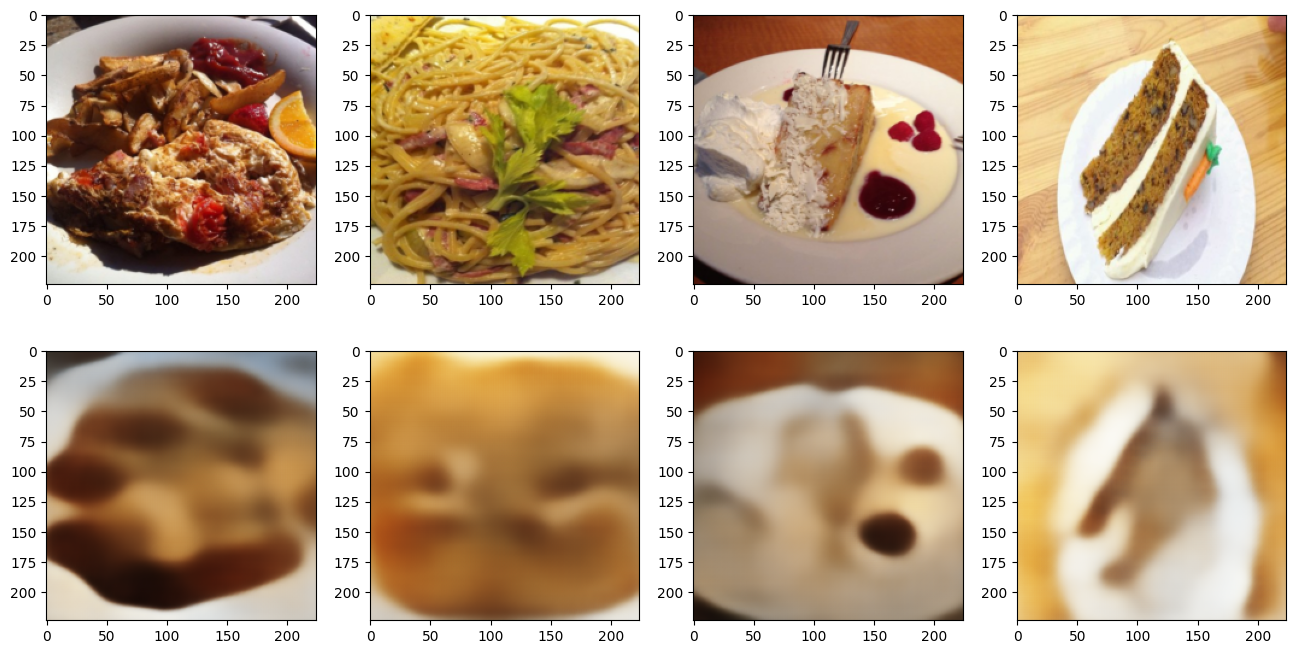

In [18]:
fig,ax = plt.subplots(2,4)
fig.set_size_inches(4*4,8)
image_ = einops.rearrange(image.cpu().numpy(), 'b c h w -> b h w c')
outputs_ = einops.rearrange(nn.Sigmoid()(outputs.detach()).cpu().numpy(), 'b c h w -> b h w c')
for idx in range(4):
    ax[0,idx].imshow(image_[idx,:,:,:])
    ax[1,idx].imshow(outputs_[idx,:,:,:])

In [22]:
fig.savefig("auto_encoder.pdf",bbox_inches="tight")

In [21]:
l

[0.6007515692771389,
 0.5625233734924782,
 0.5541386593719424,
 0.549821352746886,
 0.5463015464356709,
 0.5437767405800408,
 0.5416019071782301,
 0.539516818704944,
 0.5376903090985293,
 0.5359922561246127]